In [337]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline  

import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf


import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import linear_model
from sklearn.model_selection import train_test_split 

import scipy.stats as stats

import math 

In [338]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Scrub - Converting data types 

In [339]:
#convert column name ['date'] from object to datetime 

#might be cool to create a function that takes any column date and converts it 

df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

In [340]:
# Obvious issue with sqft_basement due to columns
#First attempt to convert failed due to ? marks so we need to remove them 

df['sqft_basement'].nunique() 

304

In [341]:
#replacing all ? with 0's - major assumption that requires data enrichment to correct
#

df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x==
                                             '?' else x)

df['sqft_basement'] = df['sqft_basement'].astype(float)

In [342]:
# Scrub - Treating Null values 

In [343]:
# Identify null values 

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [344]:
# Look for columns where all 3 are missing 
#This isnt a huge % of the data so we allow it 

print('Number Missing All Three:',
     len(df[(df.waterfront.isnull())
           & (df.view.isnull())
           & (df.yr_renovated.isnull())]))

Number Missing All Three: 2


In [345]:
#Repeat the same process for view which indicates how many times a house has been viewed

#We replaced all views with a median value, its safe to assume houses on the market in these areas are quite popular and viewed 
median = df['view'].median()
df['view'] = df['view'].fillna(value=median)#Waterfront 0 = No waterfront, 1=Waterfront 

#Making all nulls 0 indicating no waterfront 

df['waterfront'].isna().sum()

df['waterfront'] = df['waterfront'].fillna(0)

In [346]:
# Assuming renovation nulls are the same as renovation yr_built 

df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [347]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Major assumptions of scrubbing 

1. Waterfront - nulls = 0 and 1 means on the waterfront, replaced all nulls with 0 

2. Filled view with median value, assuming all houses are viewed or in demand (justification is this is a major area with lots of people moving there) 

3. if there is no yr_renovated, fill with most recent year built 

In [348]:
#dropped all duplicates for id 
#inplace = True changes the dataframe permanently

df.drop_duplicates(subset=['id'], inplace=True)

# Scrubbing - Outliers 

# Exploring Categorical & Numerical Variables 

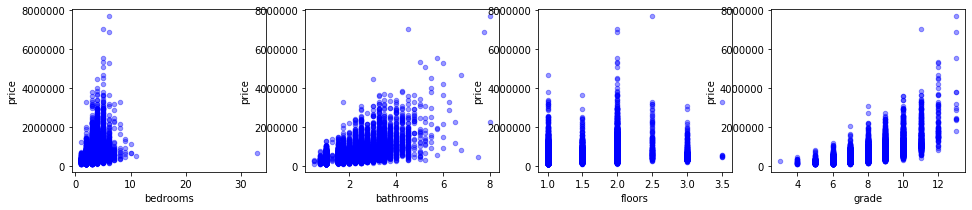

In [349]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

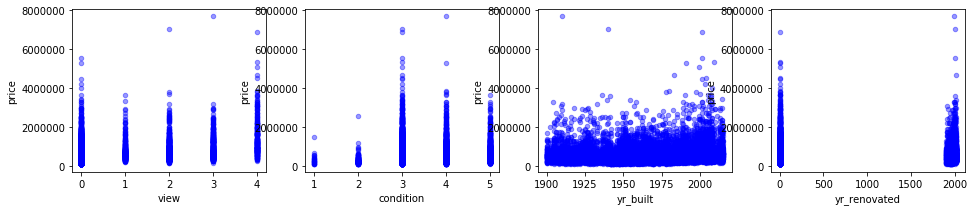

In [350]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['view', 'condition', 'yr_built', 'yr_renovated'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Checking for Linear Relationships to find the best data
## Comment/uncomment cell below for outlier removal code 

In [351]:
#sqft_living 

indexNames = df[df['sqft_living'] >= 5000 ].index
df.drop(indexNames , inplace=True)

# sqft_above 

indexNames = df[df['sqft_above'] >= 4500 ].index
df.drop(indexNames , inplace=True)

#sqft_basement 

indexNames = df[df['sqft_basement'] >= 2000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_lot outliers

indexNames = df[df['sqft_lot'] >= 100000 ].index
df.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers

indexNames = df[df['sqft_living15'] >= 4500 ].index
df.drop(indexNames , inplace=True)


# dropping sqft_lot15 outliers

indexNames = df[df['sqft_lot15'] >= 100000 ].index
df.drop(indexNames , inplace=True)


# dropping grade outliers
indexNames = df[df['grade'] == 3 ].index
df.drop(indexNames , inplace=True)

indexNames = df[df['grade'] == 13 ].index
df.drop(indexNames , inplace=True)

# dropping bedroom outliers over 8 rooms
indexNames = df[df['bedrooms'] >= 8 ].index
df.drop(indexNames , inplace=True)

#drop houses over a million
indexNames = df[df['price'] >= 1000000].index
df.drop(indexNames, inplace=True)

In [352]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Regression in a clean style 

In [353]:
x = pd.DataFrame(df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 
     'sqft_basement',
       'sqft_living15']])
y = pd.DataFrame(df['price'])
y.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [354]:
x.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,sqft_living15
count,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000,19394.000000
mean,3.314169,2.030435,1934.837011,9811.660204,1.471821,254.289058,1897.099722
std,0.865549,0.692493,728.711322,10606.555760,0.538104,393.426251,594.008619
min,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,460.000000
25%,3.000000,1.500000,1390.000000,5000.000000,1.000000,0.000000,1460.000000
50%,3.000000,2.000000,1830.000000,7390.000000,1.000000,0.000000,1780.000000
75%,4.000000,2.500000,2390.000000,9990.000000,2.000000,500.000000,2240.000000
max,7.000000,5.750000,4940.000000,99916.000000,3.500000,1990.000000,4495.000000


In [355]:
reg=linear_model.LinearRegression()

In [356]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [357]:
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [358]:
reg.coef_ #weights of each coefficent, their  

array([[-2.12805284e+04, -6.89662899e+03,  1.13442079e+02,
        -1.18723243e+00,  3.77017711e+04,  5.02076243e+01,
         8.45834582e+01]])

In [359]:
pred = reg.predict(x_test) #make predictions

In [360]:
pred[[1, 5, 10]] #see predictions

array([[385453.96608603],
       [514898.50910616],
       [496966.5379404 ]])

In [361]:
y_test.iloc[[1,5,10]]

,price
4871,498800.0
2053,349000.0
8140,477500.0


In [362]:
# mean squared error

np.mean((pred-y_test)**2)

price    2.199169e+10
dtype: float64

In [363]:
# root mean squared error

np.sqrt(((pred-y_test)**2).mean())

price    148295.94044
dtype: float64

In [364]:
# Redo the P value Test 

In [365]:
x2 = sm.add_constant(x)

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [366]:
est=sm.OLS(y, x2)

In [367]:
est2=est.fit()

In [368]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     1861.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:13   Log-Likelihood:            -2.5873e+05
No. Observations:               19394   AIC:                         5.175e+05
Df Residuals:                   19386   BIC:                         5.175e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.105e+05   5604.201     19.711

In [369]:
x = pd.DataFrame(df[['sqft_lot', 'floors', 'sqft_living', 'bathrooms', 'bedrooms']])
y = pd.DataFrame(df['price'])

In [370]:
reg=linear_model.LinearRegression()

In [371]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     2300.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:16   Log-Likelihood:            -2.5920e+05
No. Observations:               19394   AIC:                         5.184e+05
Df Residuals:                   19388   BIC:                         5.185e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.886e+05   5124.711     36.807      

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Regression with just grade 

In [372]:
dummies = pd.get_dummies(df.grade, dtype=int)


price =  df['price']

In [373]:
merged_grade = pd.concat([price, dummies], axis='columns')

In [374]:
merged_grade.columns

Index(['price', 4, 5, 6, 7, 8, 9, 10, 11], dtype='object')

In [375]:
x = pd.DataFrame(merged_grade.iloc[:,1:9])
y = pd.DataFrame(merged_grade['price'])
x.head

<bound method NDFrame.head of        4   5   6   7   8   9   10  11
0       0   0   0   1   0   0   0   0
1       0   0   0   1   0   0   0   0
2       0   0   1   0   0   0   0   0
3       0   0   0   1   0   0   0   0
4       0   0   0   0   1   0   0   0
...    ..  ..  ..  ..  ..  ..  ..  ..
21592   0   0   0   0   1   0   0   0
21593   0   0   0   0   1   0   0   0
21594   0   0   0   1   0   0   0   0
21595   0   0   0   0   1   0   0   0
21596   0   0   0   1   0   0   0   0

[19394 rows x 8 columns]>

In [376]:
merged_grade = pd.concat([price, dummies], axis='columns')

In [377]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1693.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:20   Log-Likelihood:            -2.5909e+05
No. Observations:               19394   AIC:                         5.182e+05
Df Residuals:                   19386   BIC:                         5.183e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.422e+05   4094.232    107.993      0.0

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [378]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Treating Year Columns

In [379]:
from datetime import date 
from datetime import datetime

In [380]:
df['last_build_date'] = abs(df['yr_built']- df['yr_renovated'])

In [381]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,last_build_date
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,1955.0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,40.0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,0.0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,1965.0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,1987.0


In [382]:
# partition the age into bins
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df['last_build_date_binned'] = pd.cut(df['last_build_date'], bins=bins, labels=labels)

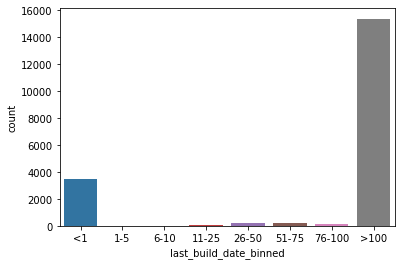

In [383]:
sns.countplot(df['last_build_date_binned'])

In [384]:
df['last_build_date_binned'].dtype

CategoricalDtype(categories=['<1', '1-5', '6-10', '11-25', '26-50', '51-75', '76-100',
                  '>100'],
                 ordered=True)

# Encode Categorical Variables 

In [403]:
dummies = pd.get_dummies(df.last_build_date_binned, dtype=int)

In [404]:
merged = pd.concat([df, dummies], axis = 'columns')

In [405]:
merged.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,last_build_date,last_build_date_binned,<1,1-5,6-10,11-25,26-50,51-75,76-100,>100
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1955.0,>100,0,0,0,0,0,0,0,1
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,40.0,26-50,0,0,0,0,1,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,<1,1,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1965.0,>100,0,0,0,0,0,0,0,1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1987.0,>100,0,0,0,0,0,0,0,1


In [388]:
merged.dtypes

id                                 int64
date                      datetime64[ns]
price                            float64
bedrooms                           int64
bathrooms                        float64
sqft_living                        int64
sqft_lot                           int64
floors                           float64
waterfront                       float64
view                             float64
condition                          int64
grade                              int64
sqft_above                         int64
sqft_basement                    float64
yr_built                           int64
yr_renovated                     float64
zipcode                            int64
lat                              float64
long                             float64
sqft_living15                      int64
sqft_lot15                         int64
last_build_date                  float64
last_build_date_binned          category
<1                                 int32
1-5             

In [390]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1693.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:49   Log-Likelihood:            -2.5909e+05
No. Observations:               19394   AIC:                         5.182e+05
Df Residuals:                   19386   BIC:                         5.183e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.422e+05   4094.232    107.993      0.0

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Running all variables   

In [391]:
x = pd.DataFrame(merged[['bedrooms', 'bathrooms', 'sqft_living',
       'floors', 'waterfront', 'view', 'condition', 'grade',
        'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15', 
        '<1', '1-5', '6-10', '11-25', '26-50',
       '51-75', '76-100', '>100']])

y = pd.DataFrame(merged['price'])

y.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [394]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1388.
Date:                Tue, 18 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:50:58   Log-Likelihood:            -2.5568e+05
No. Observations:               19394   AIC:                         5.114e+05
Df Residuals:                   19375   BIC:                         5.115e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.915e+06   7.79e+04     50.249

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [395]:
# root mean squared error

np.sqrt(((pred-y_test)**2).mean())

price    127131.449518
dtype: float64

# Merging Grade and Binned Ages at Categorical Variable

In [406]:
grade = pd.get_dummies(df.grade, drop_first=True)

In [407]:
merged2 = pd.concat([merged, grade], axis='columns')
merged2.columns

Index([                    'id',                   'date',
                        'price',               'bedrooms',
                    'bathrooms',            'sqft_living',
                     'sqft_lot',                 'floors',
                   'waterfront',                   'view',
                    'condition',                  'grade',
                   'sqft_above',          'sqft_basement',
                     'yr_built',           'yr_renovated',
                      'zipcode',                    'lat',
                         'long',          'sqft_living15',
                   'sqft_lot15',        'last_build_date',
       'last_build_date_binned',                     '<1',
                          '1-5',                   '6-10',
                        '11-25',                  '26-50',
                        '51-75',                 '76-100',
                         '>100',                        5,
                              6,                        

In [441]:
x = pd.DataFrame(merged2[['bedrooms', 'bathrooms', 'sqft_living',
       'floors', 'waterfront', 'view', 'condition', 'grade',
        'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15','<1',
                          '1-5',                   '6-10',
                        '11-25',                  '26-50',
                        '51-75',                 '76-100',
                         '>100',                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11]])

In [442]:
y = pd.DataFrame(merged, columns=['price'])
y.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [443]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg.fit(x_train, y_train)

pred = reg.predict(x_test) #make predictions

x2 = sm.add_constant(x)

est=sm.OLS(y, x2)

est2=est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     1048.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        00:09:28   Log-Likelihood:            -2.5564e+05
No. Observations:               19394   AIC:                         5.113e+05
Df Residuals:                   19369   BIC:                         5.115e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.731e+06   7.96e+04     46.906

C:\Users\User\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [411]:
np.sqrt(((pred-y_test)**2).mean())

price    127098.691731
dtype: float64

# Perform a Train-Test Split

In [412]:
from sklearn.model_selection import train_test_split

In [414]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [415]:
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

14545 4849 14545 4849


# Apply your model to the train set 

In [416]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [417]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [418]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Calculate predictions on training and test sets 

In [419]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [420]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [421]:
y_hat_test

array([[551145.0152402 ],
       [529054.4794364 ],
       [464617.71182854],
       ...,
       [343091.1183805 ],
       [583639.25173447],
       [734916.2534037 ]])

# Calculate training and test residuals 

In [422]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

# Calculate Mean Squared Error

In [423]:
from sklearn.metrics import mean_squared_error

In [424]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 16502118272.851835
Test Mean Squarred Error: 16419305395.673643


In [425]:
import math 

print(math.sqrt(test_mse))

128137.83748633205


# Evaluate the effect of train-test split size 

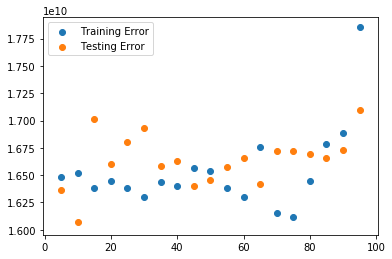

In [427]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))

plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

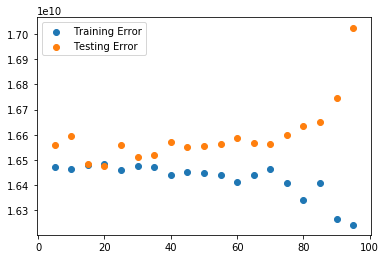

In [429]:
random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

In [431]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, x, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x, y, cv=20, scoring='neg_mean_squared_error'))

# Train-test split 

In [434]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [435]:
# A brief preview of train-test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

15515 3879 15515 3879


# Fit the model

In [436]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

# Residuals and MSE

In [437]:
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)
test_mse

16582079943.926758